### Further clean RISK variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from itertools import combinations
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, print_percentile, 
    generate_nunique_and_nulls, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
# df_list = drop_temp_columns(df_list)

In [7]:
START = time.time()

In [8]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Read Data

In [9]:
%%time
train = read_file(f"../{RAW_DATA_PATH}/train_parquet_rounded/risk.parquet")
test = read_file(f"../{RAW_DATA_PATH}/test_parquet_rounded/risk.parquet")

Shape of data: (5531451, 33)
Shape of data: (11363762, 32)
CPU times: user 9.49 s, sys: 5.59 s, total: 15.1 s
Wall time: 4.42 s


In [10]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 5.77 s, sys: 612 ms, total: 6.38 s
Wall time: 6.35 s


In [11]:
del test

In [12]:
# %%time
# labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
# if "target" not in train.columns:
#     train = train.merge(labels, on="customer_ID", how="left")

In [13]:
train.shape, public_test.shape, private_test.shape

((5531451, 33), (5719469, 32), (5644293, 32))

In [14]:
risk_variables = get_cols(train, ["R_"])

In [15]:
print(sorted(risk_variables))

['R_1', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9']


In [16]:
df_list = [train, public_test, private_test]

In [17]:
gc.collect()

72

In [18]:
# for df in df_list:
#     insert_row_number(df)

### Rounding

#### Round to 2 decimals

In [19]:
# # Skip some columns
# col_to_round = list(set(risk_variables) - set([]))

# %%time
# risk_variables_psi_list = []
# for col in tqdm(col_to_round):
#     pre_round = check_psi(df_list, col)[1]
#     df_list = round_dfs(df_list, col, decimals=2, add_new_col=False, nb_workers=8)
#     post_round = check_psi(df_list, col)[1]
#     risk_variables_psi_list.append((col, pre_round, post_round))

# risk_psi_df = pd.DataFrame(risk_variables_psi_list, columns=["feature", "psi_before", "psi_after"])

# risk_psi_df.loc[risk_psi_df["psi_before"] < risk_psi_df["psi_after"]]

# train = df_list[0]
# test = pd.concat(df_list[1:], axis=0)
# test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)
# train.to_parquet(f"../{RAW_DATA_PATH}/train_parquet_rounded/risk.parquet")
# test.to_parquet(f"../{RAW_DATA_PATH}/test_parquet_rounded/risk.parquet")

### Check Nunique & Null

In [20]:
# %%time
# diff_nunique_df, diff_null_df = generate_nunique_and_nulls(df_list)

In [21]:
# diff_nunique_df

In [22]:
# diff_null_df

In [23]:
temp = train[[f"R_{number}" for number in [13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 28]]]

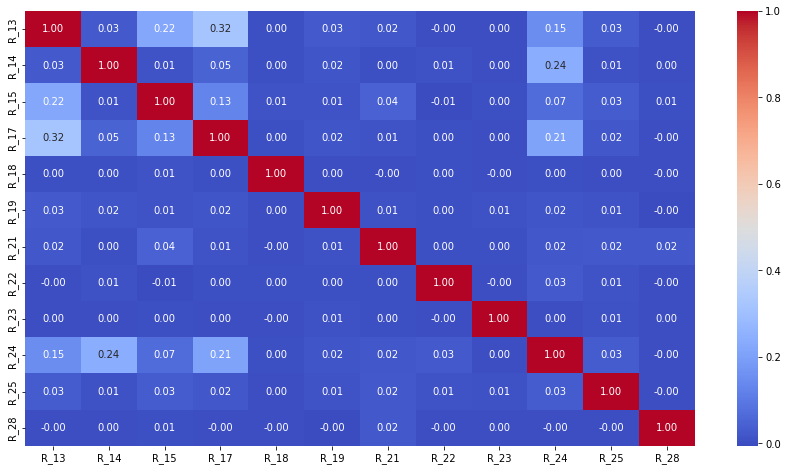

In [24]:
plot_heatmap(temp.corr(), annot=True, fmt=".2f")

In [25]:
temp = train[[f"R_{number}" for number in [15, 18, 19, 21, 22, 23, 25, 28]]]

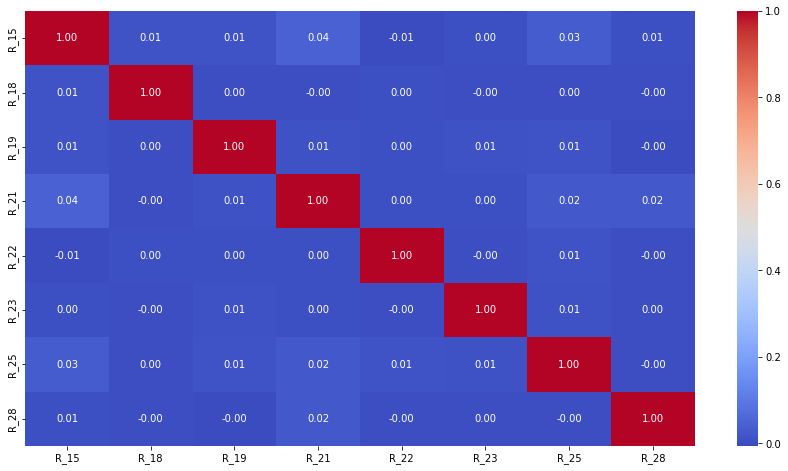

In [26]:
plot_heatmap(temp.dropna().corr(), annot=True, fmt=".2f")

### R_13, R_17 => R_137

In [27]:
for df in df_list:
    df["R_13"] = df["R_13"].replace(0, np.nan)
    df["R_13"] = np.where(df["R_13"] > 0, 1, 0)
    df["R_17"] = np.where(df["R_17"] > 0, 1, 0)
    df["R_137"] = np.where((df["R_17"] + df["R_13"]) > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


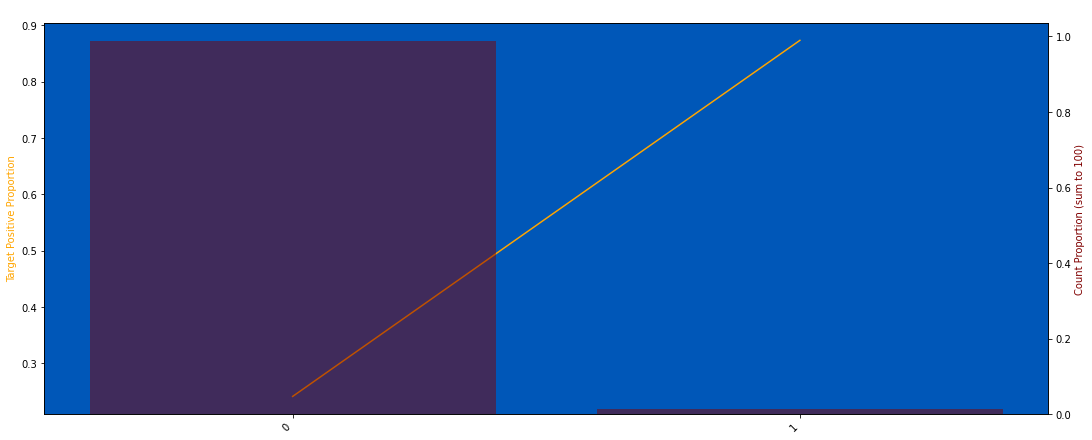

In [28]:
plot_target_check(train, "R_137", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

### R_14, R_24 => R_124

In [29]:
for df in df_list:
    df["R_14"] = np.where(df["R_14"] > 0, 1, 0)
    df["R_124"] = df["R_14"] + df["R_24"]

0 null count, 0.000 null proportion
nan of the targets have label = 1


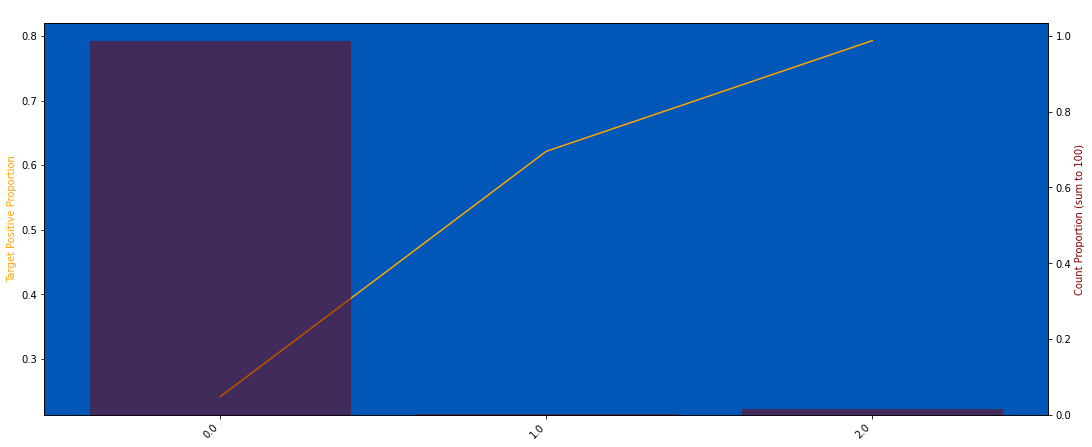

In [30]:
plot_target_check(train, "R_124", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

### R_18, R_19 => R_1819

In [31]:
for df in df_list:
    df["R_18"] = np.where(df["R_18"] > 0, 1, 0)
    df["R_1819"] = df["R_18"] + df["R_19"]

0 null count, 0.000 null proportion
nan of the targets have label = 1


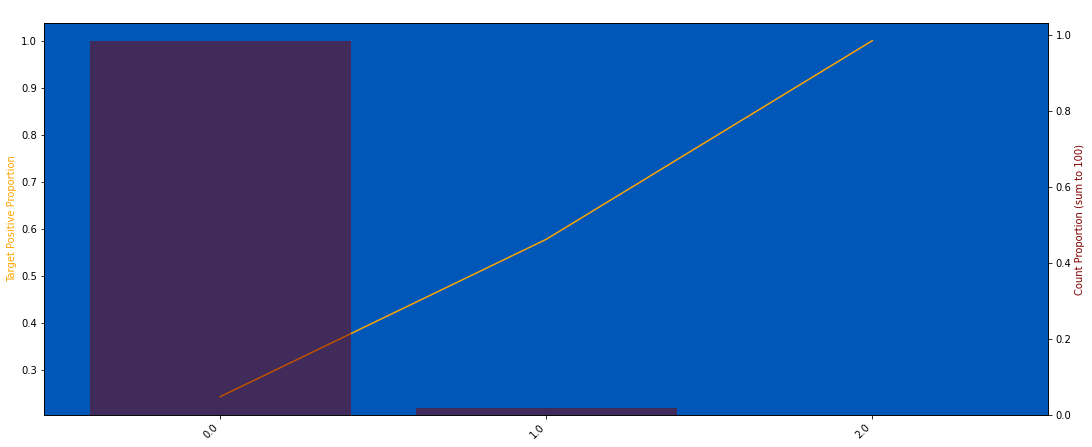

In [32]:
plot_target_check(train, "R_1819", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

### R_15, R_21, R_22 => R_152

In [33]:
for df in df_list:
    df["R_152"] = (df["R_15"] + df["R_21"] + df["R_22"]).replace(3, 2) 

0 null count, 0.000 null proportion
nan of the targets have label = 1


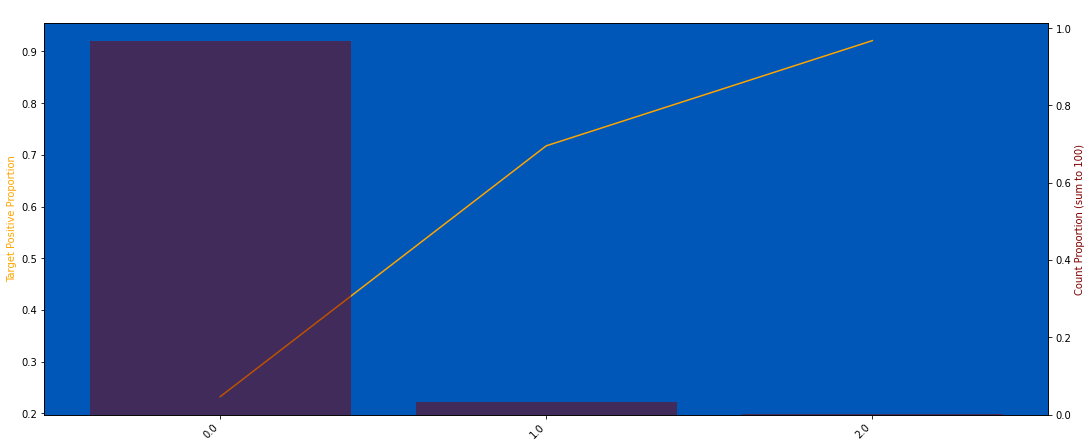

In [34]:
plot_target_check(train, "R_152", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

### R_23, R_25, R_28 => R_2358

In [35]:
for df in df_list:
    df["R_2358"] = df["R_23"] + df["R_25"] + df["R_28"]

0 null count, 0.000 null proportion
nan of the targets have label = 1


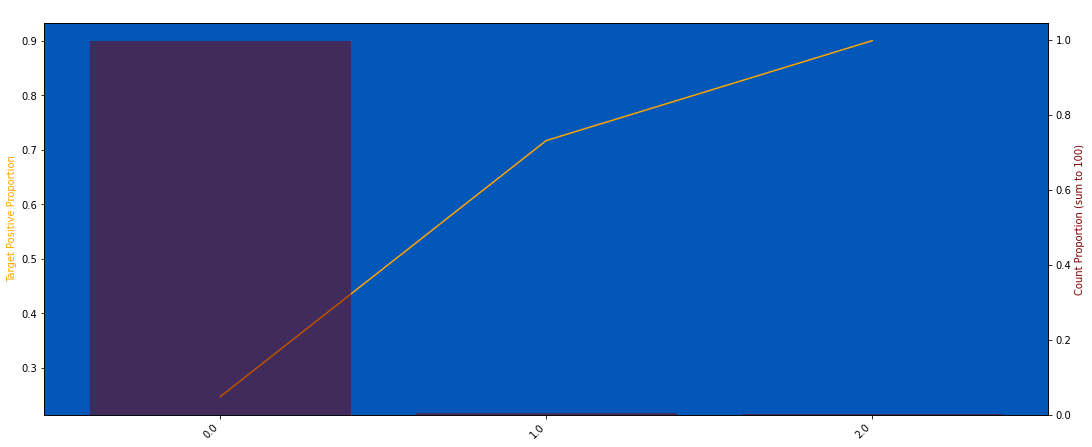

In [36]:
plot_target_check(train, "R_2358", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [37]:
for df in df_list:
    df.drop(columns=["R_13", "R_14", "R_15", "R_17", "R_18", "R_19", "R_21", "R_22", "R_23", "R_24", "R_25", "R_28"], errors="ignore", inplace=True)

### R_1 @Integer, Increasing

In [38]:
for df in df_list:
    df["R_1"] = (df["R_1"] * 4).round(0)

In [39]:
print_percentile(df_list, "R_1", 99.999)

99.999th percentile:
train : 10.0
public test : 10.0
private test : 10.0


In [40]:
for df in df_list:
    df = clip_col(df, "R_1", top_value=10, add_new_col=False)
    df["R_1"] += 1

0 null count, 0.000 null proportion
nan of the targets have label = 1


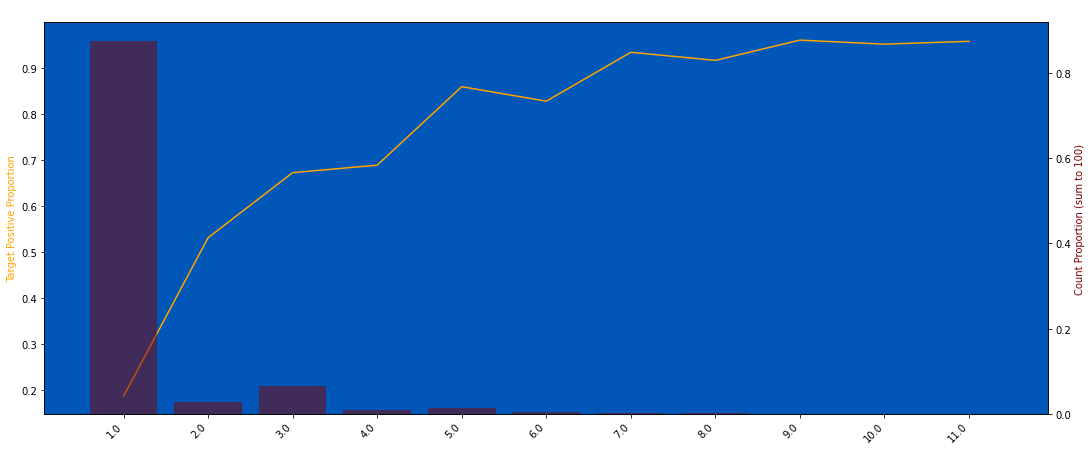

In [41]:
plot_target_check(train, "R_1", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [42]:
# plot_train_test_distribution(df_list, "R_1", nunique_thr=10000, without_drop_tail=True)

### R_2 @Binary, Increasing

0 null count, 0.000 null proportion
nan of the targets have label = 1


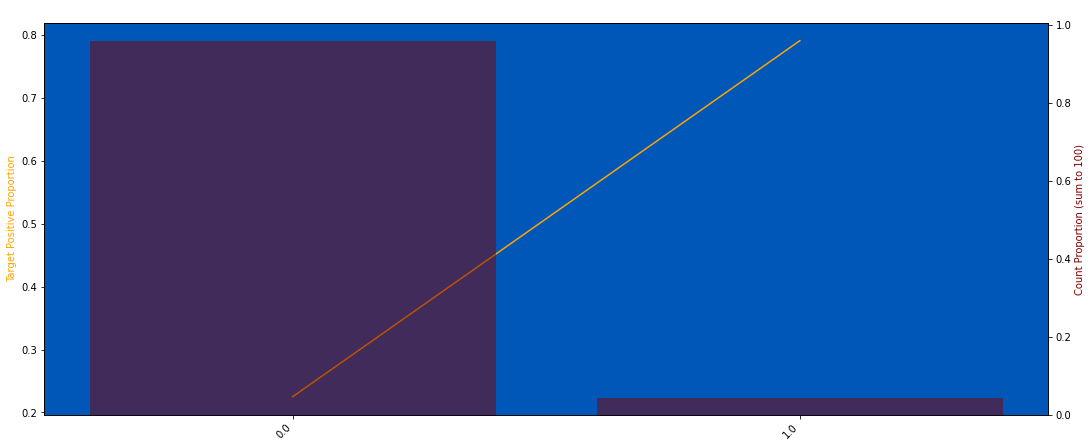

In [43]:
plot_target_check(train, "R_2", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [44]:
# plot_train_test_distribution(df_list, "R_2", nunique_thr=100)

### R_3 @Integer, Increasing


In [45]:
# plot_target_check(train, "R_3", q=50, use_raw_bin=True)

In [46]:
print_percentile(df_list, "R_3", 99.999)

99.999th percentile:
train : 6.168549999967217
public test : 5.8
private test : 5.0


In [47]:
for df in df_list:
    df = clip_col(df, "R_3", top_value=5, add_new_col=False)
    df["R_3"] = (df["R_3"] * 10) + 1

0 null count, 0.000 null proportion
nan of the targets have label = 1


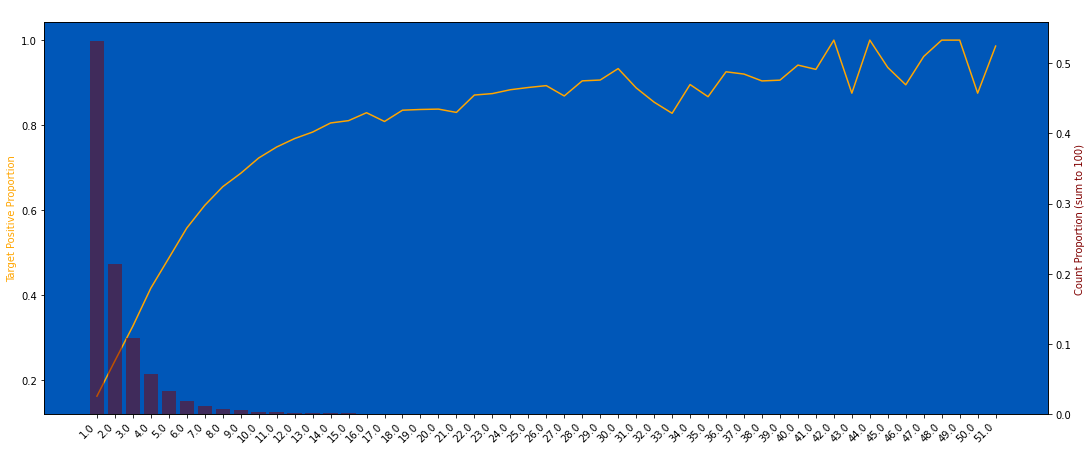

In [48]:
plot_target_check(train, "R_3", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True, without_drop_tail=True)

In [49]:
# plot_train_test_distribution(df_list, "R_3", nunique_thr=100, without_drop_tail=True)

### R_4 @Binary, Increasing

0 null count, 0.000 null proportion
nan of the targets have label = 1


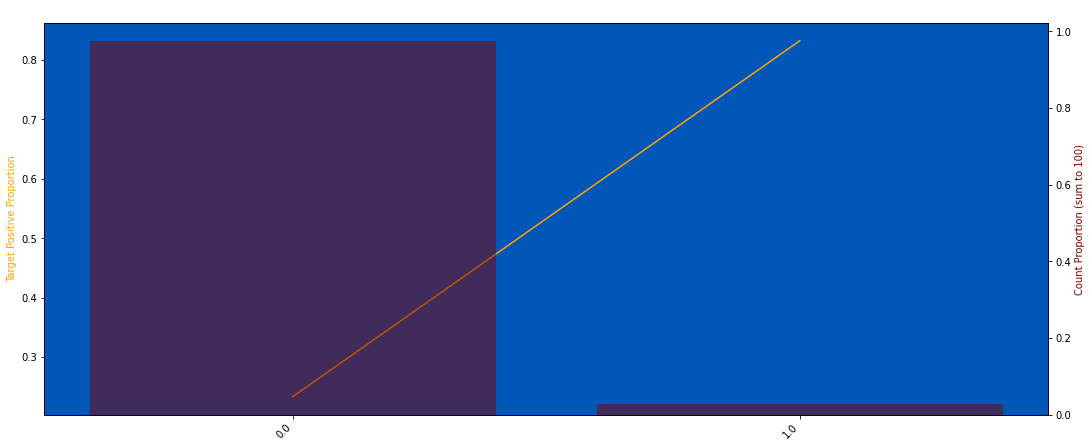

In [50]:
plot_target_check(train, "R_4", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True, without_drop_tail=True)

In [51]:
# plot_train_test_distribution(df_list, "R_4", nunique_thr=100, without_drop_tail=True)

### R_5 @Integer, Increasing

In [52]:
# plot_target_check(train, "R_5", q=50, use_raw_bin=True, nunique_thr=2)

In [53]:
print_percentile(df_list, "R_5", 99)

99th percentile:
train : 1.0
public test : 1.0
private test : 1.0


In [54]:
for df in df_list:
    df["R_5"] *= 2
    df = clip_col(df, "R_5", top_value=12, add_new_col=False)
    df["R_5"] = df["R_5"].replace(0, np.nan)

5374133 null count, 0.972 null proportion
0.2324 of the targets have label = 1


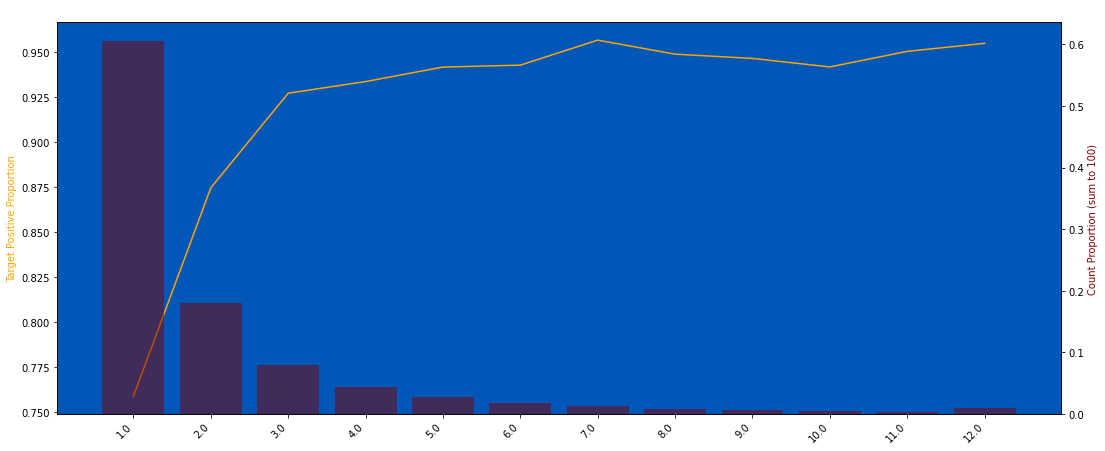

In [55]:
plot_target_check(train, "R_5", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True, without_drop_tail=True)

In [56]:
# plot_train_test_distribution(df_list, "R_5", nunique_thr=100, without_drop_tail=True)

### R_6 @Continuous, Increasing

In [57]:
# plot_target_check(train, "R_6", q=50, use_raw_bin=True)

In [58]:
print_percentile(df_list, "R_6", 99.5)

99.5th percentile:
train : 2.51
public test : 2.31
private test : 2.23


In [59]:
for df in df_list:
    df["R_6"] = df["R_6"].replace(0, np.nan)
    df = clip_col(df, "R_6", top_value=2.5, add_new_col=False)

5334423 null count, 0.964 null proportion
0.2286 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


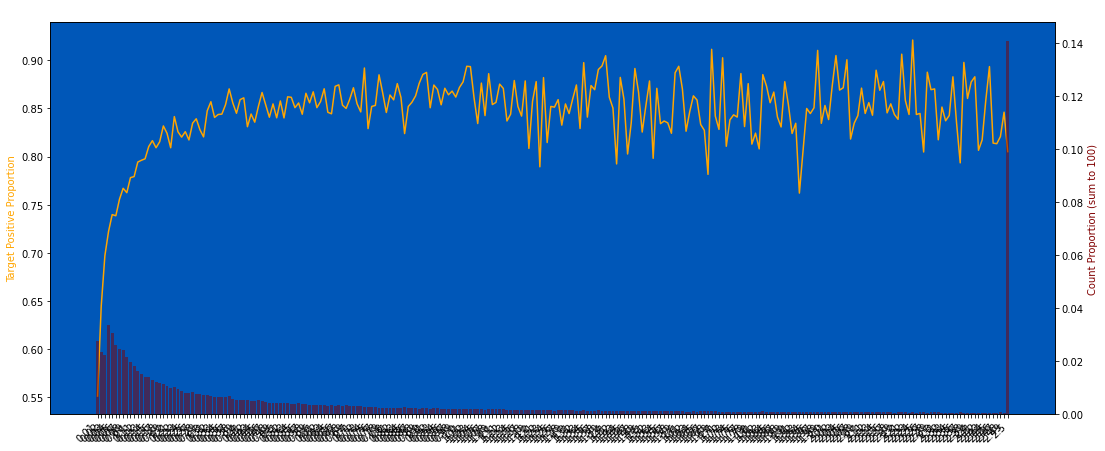

In [60]:
plot_target_check(train, "R_6", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=False)

In [61]:
# plot_train_test_distribution(df_list, "R_6", nunique_thr=5000)

### R_7 @Binary, Increasing

In [62]:
# plot_target_check(train, "R_7", q=50, use_raw_bin=True, nunique_thr=200, strfy_x=True)

In [63]:
for df in df_list:
    df["R_7"] = np.where(df["R_7"] > 0, 1, 0)

In [64]:
describe_all(df_list, "R_7")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0262,0.0265,0.0265
std,0.1598,0.1605,0.1607
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,1.0000,1.0000,1.0000
null_proportion,0.0000,0.0000,0.0000


0 null count, 0.000 null proportion
nan of the targets have label = 1


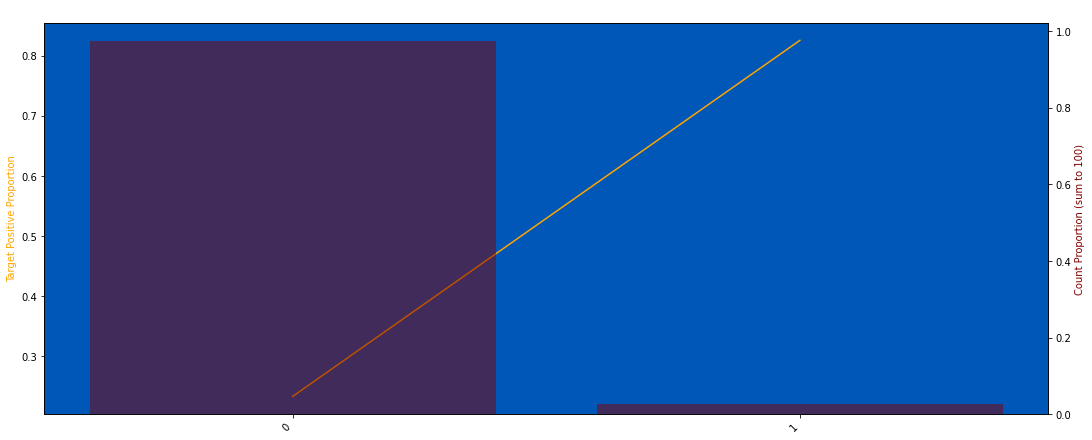

In [65]:
plot_target_check(train, "R_7", q=50, use_raw_bin=False, nunique_thr=3, strfy_x=True)

In [66]:
# plot_train_test_distribution(df_list, "R_7", nunique_thr=20000)

### R_8 @Integer, Increasing

In [67]:
# plot_target_check(train, "R_8", q=50, use_raw_bin=True)

In [68]:
%%time
df_list = round_dfs(df_list, col="R_8", decimals=1, add_new_col=False)

CPU times: user 778 ms, sys: 1.98 s, total: 2.75 s
Wall time: 3.81 s


In [69]:
print_percentile(df_list, "R_8", 99.99)

99.99th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [70]:
for df in df_list:
    df["R_8"] = df["R_8"].replace(0, np.nan)
    df = clip_col(df, "R_8", top_value=9, add_new_col=False)

5416683 null count, 0.979 null proportion
0.2371 of the targets have label = 1


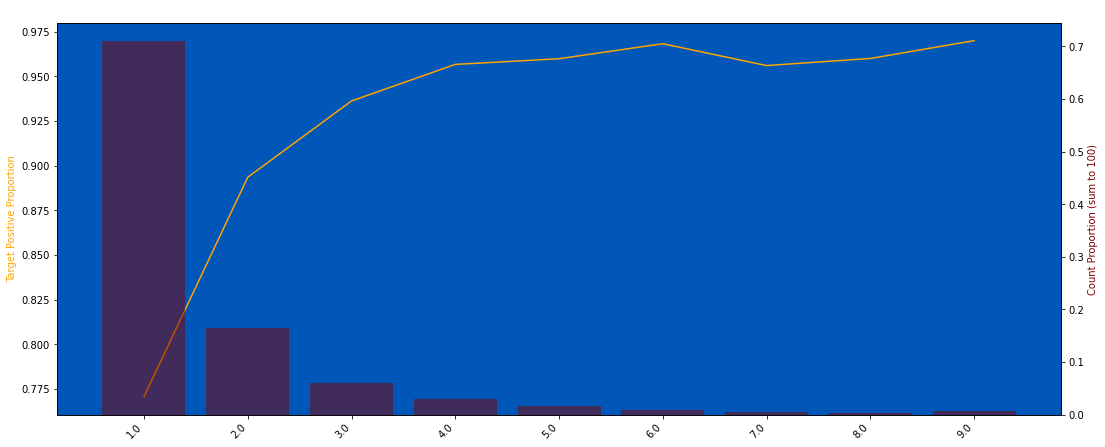

In [71]:
plot_target_check(train, "R_8", q=50, use_raw_bin=True, nunique_thr=30000, strfy_x=True, without_drop_tail=True)

In [72]:
# plot_train_test_distribution(df_list, "R_8", nunique_thr=100, without_drop_tail=True)

### R_9 @Integer, Increasing

In [73]:
# plot_target_check(train, "R_9", q=50, use_raw_bin=True)

In [74]:
%%time
df_list = round_dfs(df_list, col="R_9", decimals=2, add_new_col=False)

CPU times: user 917 ms, sys: 1.96 s, total: 2.88 s
Wall time: 4.58 s


In [75]:
for df in df_list:
    df["R_9"] = (df["R_9"] / 0.167).round(0)
    df["R_9"] = 10 - df["R_9"].replace(0, 1)

5218918 null count, 0.943 null proportion
0.2293 of the targets have label = 1


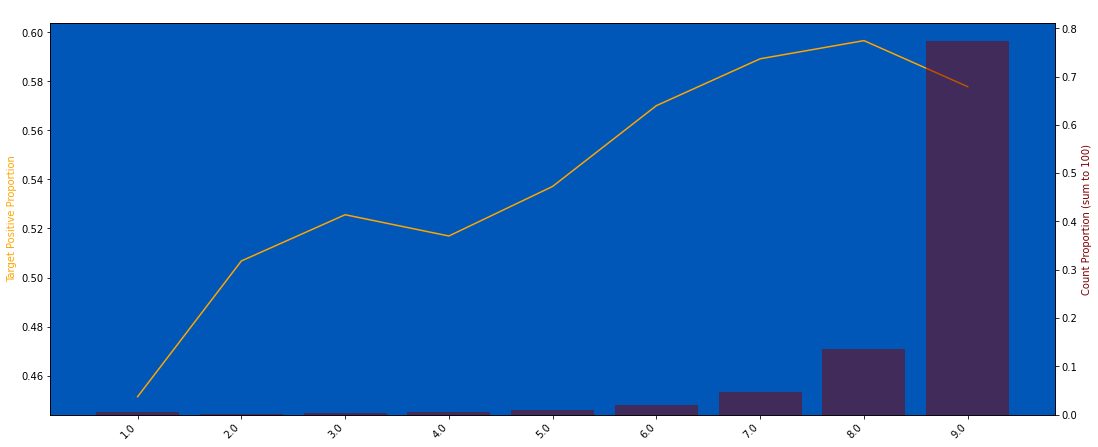

In [76]:
plot_target_check(train, "R_9", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [77]:
# plot_train_test_distribution(df_list, "R_9", nunique_thr=100, without_drop_tail=True)

### R_10 @Integer, Increasing

In [78]:
# plot_target_check(train, "R_10", q=50, use_raw_bin=True)

In [79]:
print_percentile(df_list, "R_10", 99.99)

99.99th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [80]:
for df in df_list:
    df["R_10"] = df["R_10"].replace(0, np.nan)
    df = clip_col(df, "R_10", top_value=6, add_new_col=False)

5271789 null count, 0.953 null proportion
0.2249 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


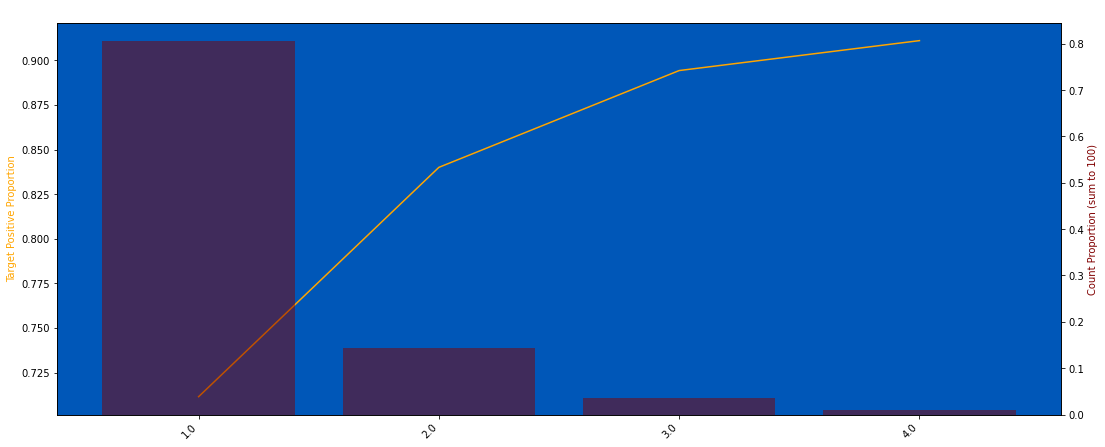

In [81]:
plot_target_check(train, "R_10", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=False)

In [82]:
# plot_train_test_distribution(df_list, "R_10", nunique_thr=100, without_drop_tail=True)

In [83]:
# binary_columns = list(set(train.nunique()[train.nunique() == 2].index.tolist()) - {"target"})

### R_11 @Integer, Increasing

In [84]:
# plot_target_check(train, "R_11", q=50, use_raw_bin=True)

In [85]:
for df in df_list:
    df["R_11"] = (df["R_11"] * 2).round(0)

In [86]:
describe_all(df_list, "R_11")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0917,0.0871,0.0857
std,0.3512,0.3416,0.3387
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,25.0000,17.0000,62.0000
null_proportion,0.0000,0.0000,0.0000


In [87]:
print_percentile(df_list, "R_11", 99.99)

99.99th percentile:
train : 5.0
public test : 5.0
private test : 5.0


In [88]:
for df in df_list:
    df["R_11"] = df["R_11"].replace(0, np.nan)
    df = clip_col(df, "R_11", top_value=5, add_new_col=False)

5108378 null count, 0.924 null proportion
0.2378 of the targets have label = 1


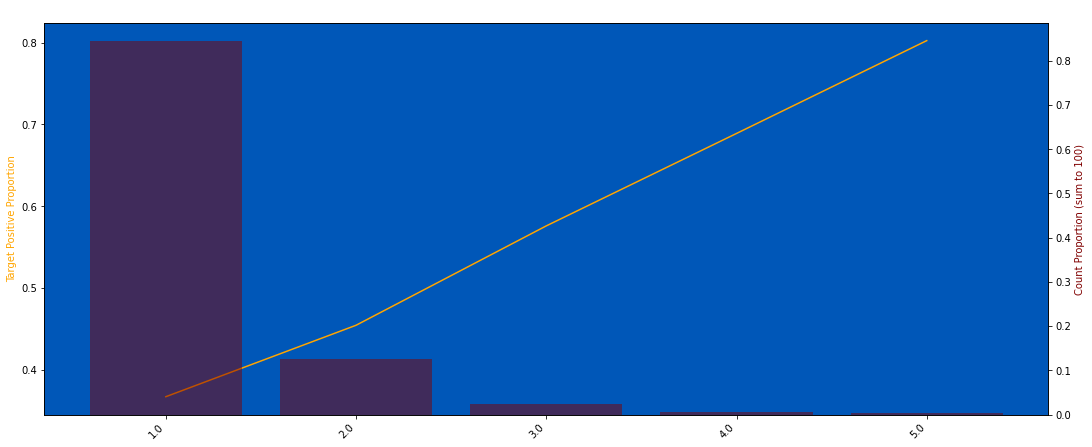

In [89]:
plot_target_check(train, "R_11", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [90]:
# plot_train_test_distribution(df_list, "R_11", nunique_thr=100, without_drop_tail=True)

### R_12 @Continuous, Increasing

In [91]:
# plot_target_check(train, "R_12", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1000)

In [92]:
print_percentile(df_list, "R_12", 99.96)

99.96th percentile:
train : 1.0
public test : 1.0
private test : 1.0


In [93]:
for df in df_list:
    df["R_12"] = df["R_12"].replace(1, np.nan)
    df = clip_col(df, "R_12", top_value=0.35, add_new_col=False)
    df["R_12"] = (0.36 - df["R_12"]).replace(0.01, np.nan)

5377465 null count, 0.972 null proportion
0.2394 of the targets have label = 1


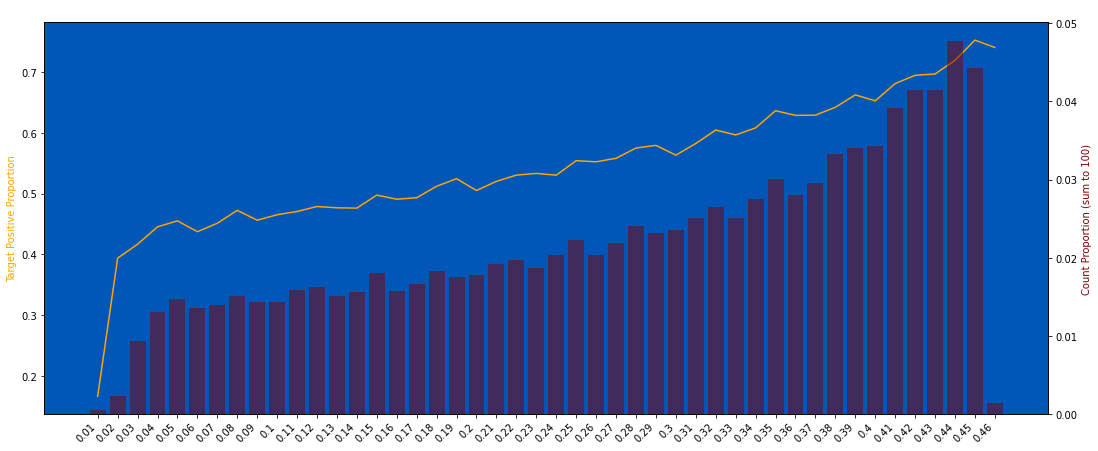

In [94]:
plot_target_check(train, "R_12", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1000, without_drop_tail=True)

In [95]:
# plot_train_test_distribution(df_list, "R_12", nunique_thr=100, without_drop_tail=True)

### R_16 @Integer, Increasing

In [96]:
# plot_target_check(train, "R_16", q=50, use_raw_bin=True)

In [97]:
for df in df_list:
    df["R_16"] *= 2

In [98]:
describe_all(df_list, "R_16")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1071,0.1111,0.1041
std,0.4785,0.4887,0.4667
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,37.0000,40.0000,33.0000
null_proportion,0.0000,0.0000,0.0000


In [99]:
print_percentile(df_list, "R_16", 99.98)

99.98th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [100]:
for df in df_list:
    df["R_16"] = df["R_16"].replace(0, np.nan)
    df = clip_col(df, "R_16", top_value=9, add_new_col=False)

5113865 null count, 0.925 null proportion
0.2327 of the targets have label = 1


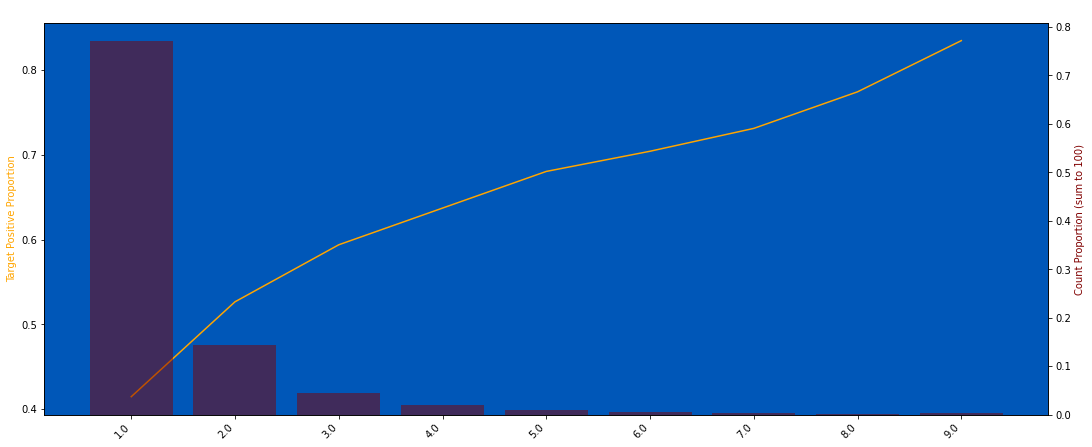

In [101]:
plot_target_check(train, "R_16", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [102]:
# plot_train_test_distribution(df_list, "R_16", nunique_thr=50000, without_drop_tail=True)

### R_20 @Binary

In [103]:
# plot_target_check(train, "R_20", q=50, use_raw_bin=True)

In [104]:
print_percentile(df_list, "R_20", 99.9)

99.9th percentile:
train : 5.0
public test : 6.0
private test : 6.0


In [105]:
for df in df_list:
    df["R_20"] = df["R_20"].replace(0, np.nan)
    df = clip_col(df, "R_20", top_value=12, add_new_col=False)

5448123 null count, 0.985 null proportion
0.2410 of the targets have label = 1


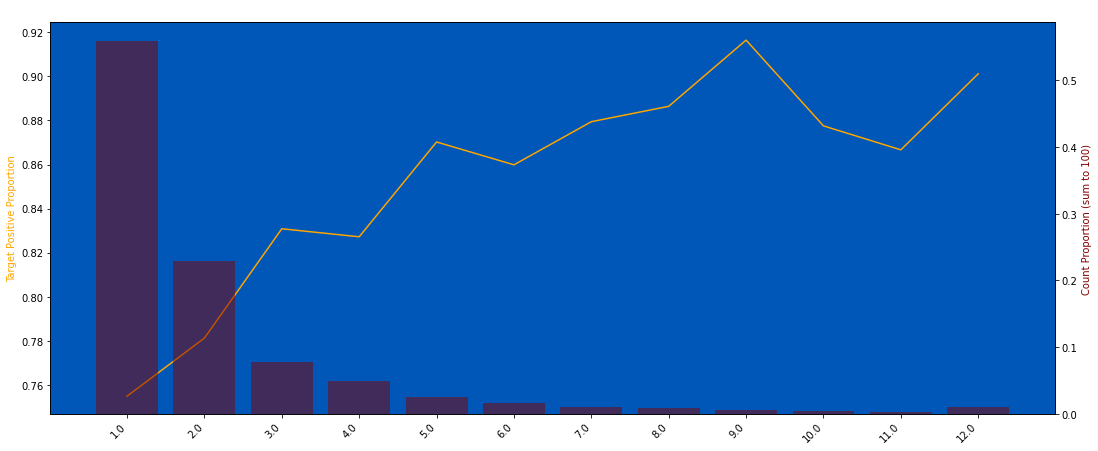

In [106]:
plot_target_check(train, "R_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [107]:
# plot_train_test_distribution(df_list, "R_20", nunique_thr=500, without_drop_tail=True)

### R_26 @Integer

In [108]:
# plot_target_check(train, "R_26", q=50, use_raw_bin=True)

In [109]:
df = clip_col(df, "R_26", top_value=2, add_new_col=False)

In [110]:
for df in df_list:
    df["R_26"] = df["R_26"] / 0.03

In [111]:
df_list = round_dfs(df_list, "R_26", decimals=0, add_new_col=False)

In [112]:
print_percentile(df_list, "R_26", 99.1)

99.1th percentile:
train : 35.0
public test : 37.0
private test : 37.0


In [113]:
for df in df_list:
    df = clip_col(df, "R_26", top_value=35, add_new_col=False)
    df["R_26"] += 1

4922146 null count, 0.890 null proportion
0.2082 of the targets have label = 1


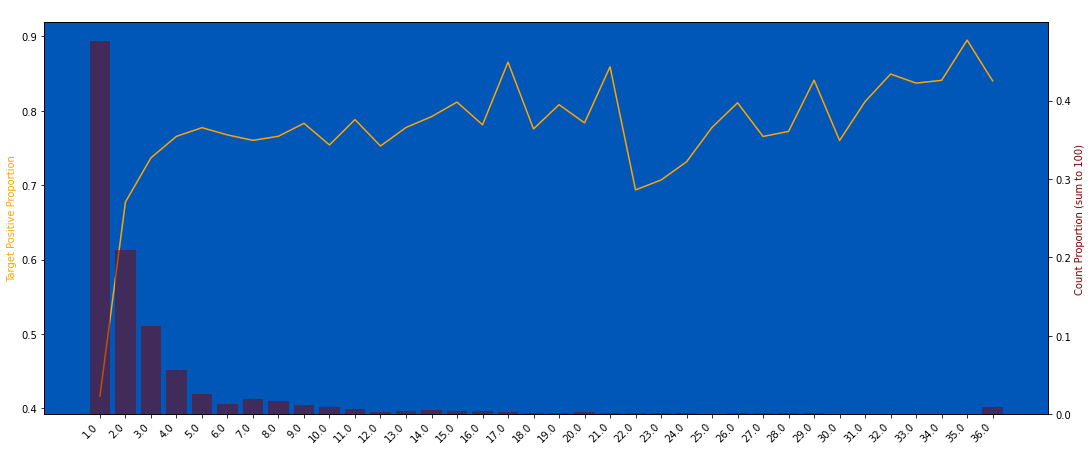

In [114]:
plot_target_check(train, "R_26", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [115]:
# plot_train_test_distribution(df_list, "R_26", nunique_thr=5000)

### R_27 @Integer

In [116]:
# plot_target_check(train, "R_27", q=50, use_raw_bin=True, strfy_x=True)

In [117]:
for df in df_list:
    df["R_27"] = np.where(df["R_27"] >= 0.9, np.nan, df["R_27"])
    df["R_27"] = ((0.04 - df["R_27"]) / 0.01 + 1)

4922437 null count, 0.890 null proportion
0.2082 of the targets have label = 1


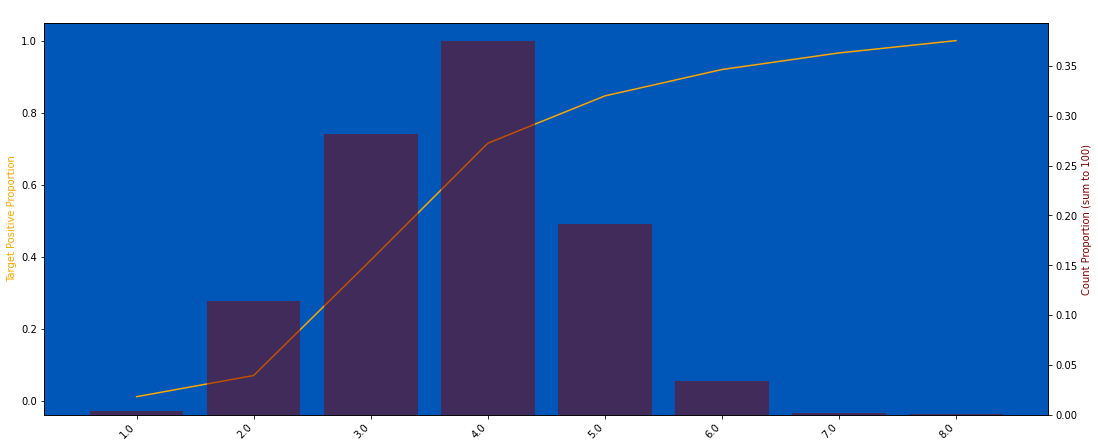

In [118]:
plot_target_check(train, "R_27", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [119]:
# plot_train_test_distribution(df_list, "R_27", nunique_thr=5000, without_drop_tail=True)

### Column checking

In [120]:
all_columns = get_cols(df_list[0], ["R_"])
print(all_columns)

['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_16', 'R_20', 'R_26', 'R_27', 'R_137', 'R_124', 'R_1819', 'R_152', 'R_2358']


In [121]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

In [122]:
print(less_unique_d_cols)

['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_16', 'R_20', 'R_26', 'R_27', 'R_137', 'R_124', 'R_1819', 'R_152', 'R_2358']


In [123]:
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

R_1 fulfill criteria to convert to integer
R_2 fulfill criteria to convert to integer
R_3 fulfill criteria to convert to integer
R_4 fulfill criteria to convert to integer
R_5 fulfill criteria to convert to integer
R_7 fulfill criteria to convert to integer
R_8 fulfill criteria to convert to integer
R_9 fulfill criteria to convert to integer
R_10 fulfill criteria to convert to integer
R_11 fulfill criteria to convert to integer
R_16 fulfill criteria to convert to integer
R_20 fulfill criteria to convert to integer
R_26 fulfill criteria to convert to integer
R_27 fulfill criteria to convert to integer
R_137 fulfill criteria to convert to integer
R_124 fulfill criteria to convert to integer
R_1819 fulfill criteria to convert to integer
R_152 fulfill criteria to convert to integer
R_2358 fulfill criteria to convert to integer


In [124]:
float64_columns = df_list[-1].select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)
    else:
        print(f"Skip {col}")

R_6 fulfill criteria to convert to float32
R_12 fulfill criteria to convert to float32


In [125]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [126]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

CPU times: user 858 ms, sys: 444 ms, total: 1.3 s
Wall time: 1.3 s


### Verify if all columns have been clipped

In [127]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|██████████| 26/26 [00:00<00:00, 68.10it/s]


In [128]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if check_psi(df_list, col)[1] >= 0.1:
        print(f"Column {col} has feature drift of {check_psi(df_list, col)[1]} on train x private-test")

100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


In [129]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 7.49 s, sys: 776 ms, total: 8.26 s
Wall time: 8.26 s


In [130]:
train.shape, test.shape

((5531451, 26), (11363762, 25))

In [131]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.355205511, 2.602301642)

In [132]:
%%time
train.to_parquet(f"./train_parquet/train_risk_.parquet")
test.to_parquet(f"./test_parquet/test_risk_.parquet")

CPU times: user 8.31 s, sys: 552 ms, total: 8.86 s
Wall time: 8.69 s


In [133]:
END = time.time()

In [134]:
print(f"{END - START:.2f} seconds elapsed")

106.95 seconds elapsed
